In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import contextily as cx
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from scipy.stats import pearsonr, spearmanr
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap

In [2]:
data_path = r"F:/IRS_Migration/"
SHELDUS = pd.read_csv("F:/SHELDUS/ORIGINAL.csv")
state    = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/usstate/cb_2018_us_state_500k.shp").to_crs('ESRI:102003')
county  = gpd.read_file("D:/Users/xiang11/Documents/GitHub/EvacuationIan/datasets/maincounty/us_conu_county.shp").to_crs('ESRI:102003')
df_pep_2010 = pd.read_csv(r"F:\PEP\co-est2010-alldata.csv", encoding='latin-1')
df_pep_2020 = pd.read_csv(r"F:\PEP\co-est2020-alldata.csv", encoding='latin-1')
SVI_10 = pd.read_csv(r"F:\PEP\SVI_2010_US_county.csv")
house_price = pd.read_csv(r"F:\LongMigration\Data\Zillow\County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
SVI_10['FIPS'] = SVI_10['FIPS'].astype("str").str.rjust(5,"0")

state = state[~state["NAME"].isin(["Alaska","Hawaii","Puerto Rico",
                                   "American Samoa","United States Virgin Islands",
                                   "Guam","Commonwealth of the Northern Mariana Islands"])]

In [3]:
SHELDUS['County FIPS'] = SHELDUS['County FIPS'].str.replace("'", "")
SHELDUS_0020 = SHELDUS[(SHELDUS["Year"]<2021) & (SHELDUS["Year"]>2000)]

In [4]:
SHELDUS_0020 = SHELDUS_0020[~((SHELDUS_0020['Year'] == 2000) & (SHELDUS_0020['Month'] <= 6))]
SHELDUS_0020 = SHELDUS_0020[~((SHELDUS_0020['Year'] == 2020) & (SHELDUS_0020['Month'] >= 7))]

In [5]:
SHELDUS_0020_sel = SHELDUS_0020[SHELDUS_0020["Hazard"].isin(['Flooding','Hurricane/Tropical Storm','Wildfire'])].reset_index(drop=True)

In [6]:
SHELDUS_0020_hurricane = SHELDUS_0020_sel[SHELDUS_0020_sel["Hazard"]=="Hurricane/Tropical Storm"].reset_index()
SHELDUS_0020_flooding  = SHELDUS_0020_sel[SHELDUS_0020_sel["Hazard"]=="Flooding"].reset_index()

In [7]:
hurricane_induced_floods = pd.merge(
    SHELDUS_0020_flooding, 
    SHELDUS_0020_hurricane, 
    on=['County FIPS', 'Year', 'Month'],
    suffixes=('_flood', '_hurricane')
)
flood_indices = hurricane_induced_floods['index_flood']

In [8]:
SHELDUS_0020_sel.loc[flood_indices, 'Hazard'] = 'Hurricane/Tropical Storm'

In [9]:
SHELDUS_0020_use = SHELDUS_0020_sel[(SHELDUS_0020_sel["Fatalities"]!=0)|(SHELDUS_0020_sel["Injuries"]!=0)|(SHELDUS_0020_sel["PropertyDmgPerCapita(ADJ 2020)"]>1)]
SHELDUS_0020_use_group = SHELDUS_0020_use.groupby(["County FIPS","Hazard","Year"]).agg({"Month":"count",
                                                                                        "Fatalities":"sum",
                                                                                        "Injuries":"sum",
                                                                                        "PropertyDmg(ADJ 2020)":"sum",
                                                                                        "PropertyDmgPerCapita(ADJ 2020)":"mean"}).reset_index()
SHELDUS_0020_use_group = SHELDUS_0020_use_group.rename(columns={"Month":"count"})
df_20_years_by_county = SHELDUS_0020_use_group.groupby(['County FIPS',"Hazard"]).agg({"count":"sum",
                                                                                        "Fatalities":"sum",
                                                                                        "Injuries":"sum",
                                                                                        "PropertyDmg(ADJ 2020)":"sum",
                                                                                        "PropertyDmgPerCapita(ADJ 2020)":"mean"}).reset_index()


In [12]:
SHELDUS_20_use_flooding  = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Flooding"]
SHELDUS_20_use_hurricane = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Hurricane/Tropical Storm"]
SHELDUS_20_use_wildfire  = df_20_years_by_county[df_20_years_by_county["Hazard"]=="Wildfire"]

In [10]:
def classify_impact(data, value_column):
    Q1 = data[value_column].quantile(0.25)
    Q3 = data[value_column].quantile(0.75)
    
    def classification(value):
        if value <= Q1:
            return 'Low Impact'
        elif (value > Q1) & (value < Q3):
            return 'Moderate Impact'
        elif value >= Q3:
            return 'High Impact'
    
    return data[value_column].apply(classification)

In [13]:
Q1_20_flooding = SHELDUS_20_use_flooding["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.25)
Q3_20_flooding = SHELDUS_20_use_flooding["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.75)

Q1_20_hurricane = SHELDUS_20_use_hurricane["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.25)
Q3_20_hurricane = SHELDUS_20_use_hurricane["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.75)

Q1_20_wildfire = SHELDUS_20_use_wildfire["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.25)
Q3_20_wildfire = SHELDUS_20_use_wildfire["PropertyDmgPerCapita(ADJ 2020)"].quantile(0.75)

In [21]:
SHELDUS_20_use_flooding['ImpactLevel'] = classify_impact(SHELDUS_20_use_flooding, "PropertyDmgPerCapita(ADJ 2020)")
SHELDUS_20_use_hurricane['ImpactLevel'] = classify_impact(SHELDUS_20_use_hurricane, "PropertyDmgPerCapita(ADJ 2020)")
SHELDUS_20_use_wildfire['ImpactLevel'] = classify_impact(SHELDUS_20_use_wildfire, "PropertyDmgPerCapita(ADJ 2020)")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_7644\2968689653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHELDUS_20_use_flooding['ImpactLevel'] = classify_impact(SHELDUS_20_use_flooding, "PropertyDmgPerCapita(ADJ 2020)")
C:\Users\xiang11\AppData\Local\Temp\ipykernel_7644\2968689653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHELDUS_20_use_hurricane['ImpactLevel'] = classify_impact(SHELDUS_20_use_hurricane, "PropertyDmgPerCapita(ADJ 2020)")
C:\Users\xiang11\AppData\Local\Temp\ipykernel_7644

In [22]:
SHELDUS_flooding_county  = list(SHELDUS_20_use_flooding["County FIPS"].unique())
SHELDUS_hurricane_county = list(SHELDUS_20_use_hurricane["County FIPS"].unique())
SHELDUS_wildfire_county  = list(SHELDUS_20_use_wildfire["County FIPS"].unique())

flooding_county  = county[county["FIPS"].isin(SHELDUS_flooding_county)].reset_index(drop=True)
hurricane_county = county[county["FIPS"].isin(SHELDUS_hurricane_county)].reset_index(drop=True)
wildfire_county  = county[county["FIPS"].isin(SHELDUS_wildfire_county)].reset_index(drop=True)

In [23]:
df_SHELDUS_20_flooding_county  = pd.merge(SHELDUS_20_use_flooding,flooding_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_20_hurricane_county = pd.merge(SHELDUS_20_use_hurricane,hurricane_county,left_on="County FIPS",right_on="FIPS")
df_SHELDUS_20_wildfire_county  = pd.merge(SHELDUS_20_use_wildfire,wildfire_county,left_on="County FIPS",right_on="FIPS")

gdf_SHELDUS_20_flooding_county = gpd.GeoDataFrame(df_SHELDUS_20_flooding_county,geometry="geometry")
gdf_SHELDUS_20_hurricane_county= gpd.GeoDataFrame(df_SHELDUS_20_hurricane_county,geometry="geometry")
gdf_SHELDUS_20_wildfire_county = gpd.GeoDataFrame(df_SHELDUS_20_wildfire_county,geometry="geometry")

In [47]:
SHELDUS_20_use_hurricane

,County FIPS,Hazard,count,Fatalities,Injuries,PropertyDmg(ADJ 2020),PropertyDmgPerCapita(ADJ 2020),ImpactLevel
1,01001,Hurricane/Tropical Storm,2,0.00,0.0,348956.00,3.644830,Low Impact
3,01003,Hurricane/Tropical Storm,4,0.00,0.0,14903583.36,18.590288,Moderate Impact
5,01005,Hurricane/Tropical Storm,2,0.00,0.0,103344.66,1.754460,Low Impact
7,01007,Hurricane/Tropical Storm,2,0.00,0.0,348956.00,8.162715,Moderate Impact
9,01009,Hurricane/Tropical Storm,1,0.00,0.0,80528.31,1.463220,Low Impact
...,...,...,...,...,...,...,...,...
4231,72133,Hurricane/Tropical Storm,1,0.00,0.0,493355.24,22.601940,Moderate Impact
4241,72149,Hurricane/Tropical Storm,3,0.00,0.1,9780611.92,120.887850,Moderate Impact
4243,72151,Hurricane/Tropical Storm,2,0.17,0.0,740032.86,9.460915,Moderate Impact
4246,72153,Hurricane/Tropical Storm,1,0.00,0.0,493355.24,10.741690,Moderate Impact


In [25]:
df_pep_2010["state"] = df_pep_2010["STATE"].astype('int64').astype('str').str.rjust(2, "0")
df_pep_2010["county"] = df_pep_2010["COUNTY"].astype('int64').astype('str').str.rjust(3, "0")
df_pep_2010["FIPS"] = df_pep_2010["state"] + df_pep_2010["county"]

df_pep_2020["state"] = df_pep_2020["STATE"].astype('int64').astype('str').str.rjust(2, "0")
df_pep_2020["county"] = df_pep_2020["COUNTY"].astype('int64').astype('str').str.rjust(3, "0")
df_pep_2020["FIPS"] = df_pep_2020["state"] + df_pep_2020["county"]

In [26]:
df_pep_0120 = pd.merge(df_pep_2010,df_pep_2020,on="FIPS")

In [27]:
correct_netmig_columns = []
for year in range(2001, 2021):
    column_name_x = f'RNETMIG{year}_x'
    column_name_y = f'RNETMIG{year}_y'
    column_name = f'RNETMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns.append(column_name_y)

In [28]:
correct_netmig_columns1 = []
for year in range(2001, 2021):
    column_name_x = f'RDOMESTICMIG{year}_x'
    column_name_y = f'RDOMESTICMIG{year}_y'
    column_name = f'RDOMESTICMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns1.append(column_name_y)

In [29]:
correct_netmig_columns2 = []
for year in range(2001, 2021):
    column_name_x = f'RINTERNATIONALMIG{year}_x'
    column_name_y = f'RINTERNATIONALMIG{year}_y'
    column_name = f'RINTERNATIONALMIG{year}'
    if column_name in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name)
    elif column_name_x in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name_x)
    elif column_name_y in df_pep_0120.columns:
        correct_netmig_columns2.append(column_name_y)

In [31]:
df_pep_0120["NetMigrationRateTotal"] = df_pep_0120[correct_netmig_columns].mean(axis=1)
df_pep_0120["NetMigrationRateDome"]  = df_pep_0120[correct_netmig_columns1].mean(axis=1)
df_pep_0120["NetMigrationRateInter"] = df_pep_0120[correct_netmig_columns2].mean(axis=1)
df_pep_0120_used = df_pep_0120[['FIPS','STNAME_x', 'CTYNAME_x', 'NetMigrationRateTotal', 'NetMigrationRateDome', 'NetMigrationRateInter']]

In [32]:
df_pep_0120_used

,FIPS,STNAME_x,CTYNAME_x,NetMigrationRateTotal,NetMigrationRateDome,NetMigrationRateInter
0,01000,Alabama,Alabama,2.276452,1.274938,1.001513
1,01001,Alabama,Autauga County,5.813354,5.764054,0.049301
2,01003,Alabama,Baldwin County,22.393108,21.326295,1.066813
3,01005,Alabama,Barbour County,-7.284080,-8.311879,1.027799
4,01007,Alabama,Bibb County,1.336304,0.909290,0.427014
...,...,...,...,...,...,...
3185,56037,Wyoming,Sweetwater County,-5.170849,-5.811242,0.640394
3186,56039,Wyoming,Teton County,3.381039,-0.109523,3.490563
3187,56041,Wyoming,Uinta County,-6.927289,-7.187357,0.260068
3188,56043,Wyoming,Washakie County,-7.130189,-7.194011,0.063821


In [33]:
df_NMR = pd.merge(df_pep_0120_used,county,on="FIPS",how="inner")
gdf_NMR = gpd.GeoDataFrame(df_NMR,geometry="geometry")

Text(0.5, 1.0, 'Net International Migration Rate from 2000-2020 (Calculated by Average Migration Rate)')

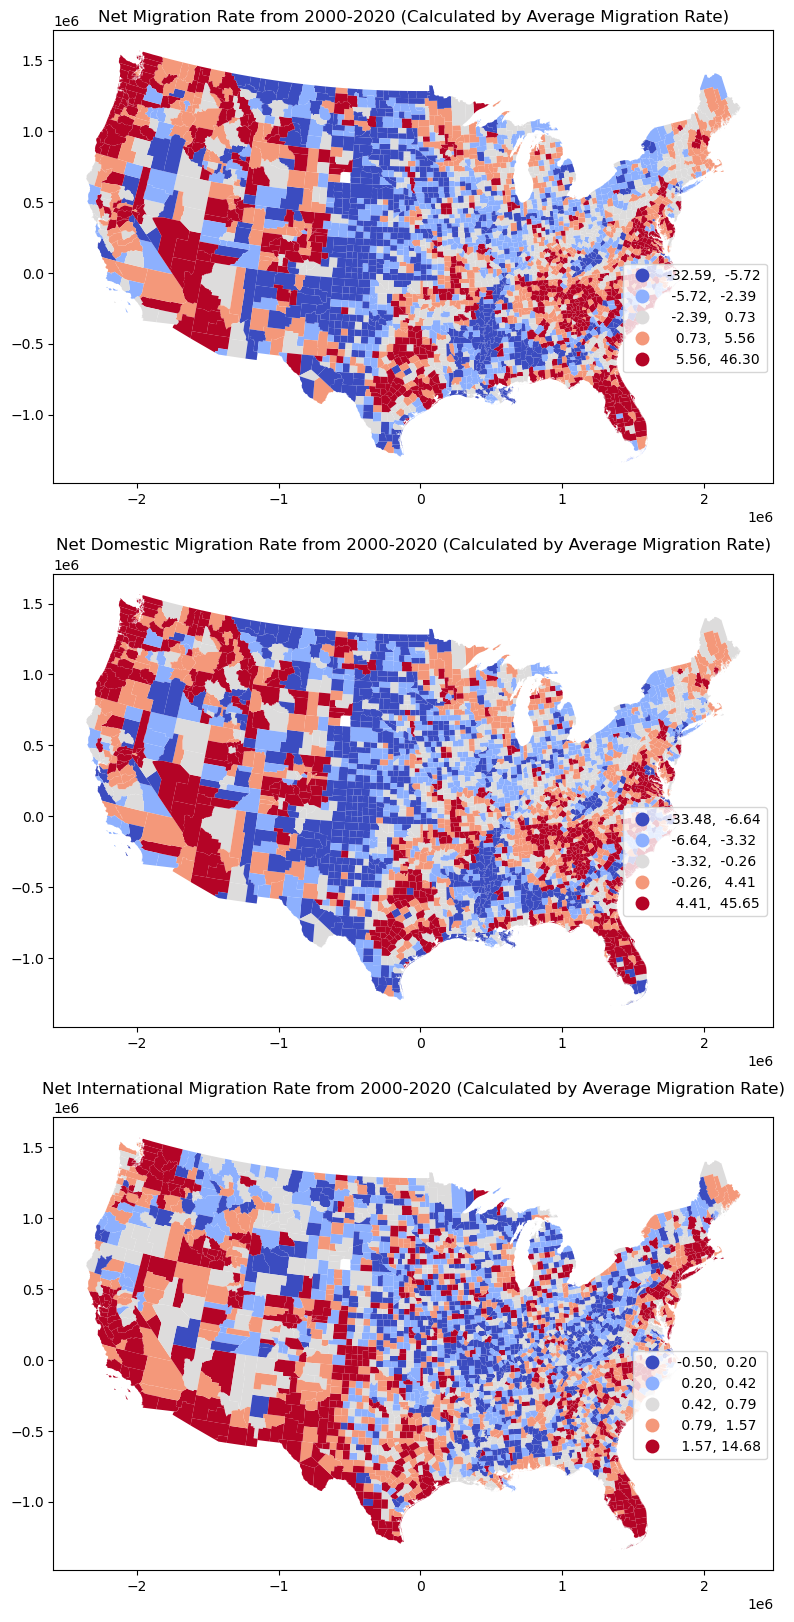

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(16, 20))
gdf_NMR.plot(column="NetMigrationRateTotal",cmap="coolwarm",
             scheme="quantiles",
#              scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[0])
leg = axes[0].get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
axes[0].set_title("Net Migration Rate from 2000-2020 (Calculated by Average Migration Rate)")

gdf_NMR.plot(column="NetMigrationRateDome",cmap="coolwarm",
             scheme="quantiles",
#              scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[1])
leg = axes[1].get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
axes[1].set_title("Net Domestic Migration Rate from 2000-2020 (Calculated by Average Migration Rate)")

gdf_NMR.plot(column="NetMigrationRateInter",cmap="coolwarm",
             scheme="quantiles",
#              scheme='userdefined',classification_kwds={'bins':[-500,-100,-50,-25,-10,-0.1,0,0.1,10,25,50,100,500]},
             legend=True,ax=axes[2])
leg = axes[2].get_legend()
leg.set_bbox_to_anchor(( 1, 0.5)) 
axes[2].set_title("Net International Migration Rate from 2000-2020 (Calculated by Average Migration Rate)")

In [35]:
used_list = ["E_P_POV","E_P_UNEMP","E_P_PCI","E_P_NOHSDIP","P_AGE65","P_AGE17","P_SNGPRNT","P_MINORITY","E_P_LIMENG","E_P_MUNIT","E_P_MOBILE","E_P_CROWD","E_P_NOVEH","P_GROUPQ"]
name_list = ["BelowPoverty","16+Unemployed","PerCapitaIncome","NoHighSchoolDiploma25+","65+","<18","single-parent household","minority","LessThanWellEnglish5+","HouseWith10+Units","MobileHome","HouseWithPop>Room","NoVehicleHousehold","GroupQuarters"]

In [59]:
SVI_10[name_list] = SVI_10[used_list]
gdf_NMR_mig = gdf_NMR[["FIPS","NetMigrationRateTotal","NetMigrationRateDome","NetMigrationRateInter"]]
SVI_10_merge = pd.merge(SVI_10,gdf_NMR_mig,on="FIPS")

In [87]:
no_hurricane_SVI = SVI_10_merge[~SVI_10_merge["FIPS"].isin(SHELDUS_hurricane_county)].reset_index()
hurricane_SVI = SVI_10_merge[SVI_10_merge["FIPS"].isin(SHELDUS_hurricane_county)].reset_index()

In [90]:
hurricane_SVI = pd.merge(hurricane_SVI,SHELDUS_20_use_hurricane,left_on="FIPS",right_on="County FIPS")

In [91]:
columns_to_normalize_se = ["BelowPoverty","16+Unemployed","PerCapitaIncome","NoHighSchoolDiploma25+","65+","<18","single-parent household","minority","LessThanWellEnglish5+","HouseWith10+Units","MobileHome","HouseWithPop>Room","NoVehicleHousehold","GroupQuarters"]
columns_to_normalize_dis = ["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)"]
columns_to_normalize_all = ["count","Fatalities","Injuries","PropertyDmgPerCapita(ADJ 2020)","BelowPoverty","16+Unemployed","PerCapitaIncome","NoHighSchoolDiploma25+","65+","<18","single-parent household","minority","LessThanWellEnglish5+","HouseWith10+Units","MobileHome","HouseWithPop>Room","NoVehicleHousehold","GroupQuarters"]

In [92]:
no_hurricane_SVI[columns_to_normalize_se] = (no_hurricane_SVI[columns_to_normalize_se] - no_hurricane_SVI[columns_to_normalize_se].mean()) / no_hurricane_SVI[columns_to_normalize_se].std()

In [93]:
X_f =  no_hurricane_SVI[name_list]
Y_f =  no_hurricane_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[name_list]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.274
Model:                               OLS   Adj. R-squared:                  0.270
Method:                    Least Squares   F-statistic:                     64.05
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):          1.20e-153
Time:                           02:30:19   Log-Likelihood:                -7840.8
No. Observations:                   2386   AIC:                         1.571e+04
Df Residuals:                       2371   BIC:                         1.580e+04
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [94]:
hurricane_SVI[columns_to_normalize_all] = (hurricane_SVI[columns_to_normalize_all] - hurricane_SVI[columns_to_normalize_all].mean()) / hurricane_SVI[columns_to_normalize_all].std()

In [96]:
X_f =  hurricane_SVI[columns_to_normalize_se]
Y_f =  hurricane_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_se]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.475
Model:                               OLS   Adj. R-squared:                  0.465
Method:                    Least Squares   F-statistic:                     45.71
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           4.12e-89
Time:                           02:30:26   Log-Likelihood:                -2455.1
No. Observations:                    721   AIC:                             4940.
Df Residuals:                        706   BIC:                             5009.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [97]:
X_f =  hurricane_SVI[columns_to_normalize_all]
Y_f =  hurricane_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_all]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.495
Model:                               OLS   Adj. R-squared:                  0.482
Method:                    Least Squares   F-statistic:                     38.16
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           2.26e-91
Time:                           02:30:44   Log-Likelihood:                -2441.7
No. Observations:                    721   AIC:                             4921.
Df Residuals:                        702   BIC:                             5008.
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [98]:
X_f =  no_hurricane_SVI[name_list]
Y_f =  no_hurricane_SVI["NetMigrationRateDome"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[name_list]
Y_f_clean = data["NetMigrationRateDome"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     NetMigrationRateDome   R-squared:                       0.266
Model:                              OLS   Adj. R-squared:                  0.262
Method:                   Least Squares   F-statistic:                     61.49
Date:                  Thu, 19 Sep 2024   Prob (F-statistic):          4.79e-148
Time:                          02:31:34   Log-Likelihood:                -7870.4
No. Observations:                  2386   AIC:                         1.577e+04
Df Residuals:                      2371   BIC:                         1.586e+04
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

In [99]:
X_f =  hurricane_SVI[columns_to_normalize_se]
Y_f =  hurricane_SVI["NetMigrationRateDome"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_se]
Y_f_clean = data["NetMigrationRateDome"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     NetMigrationRateDome   R-squared:                       0.456
Model:                              OLS   Adj. R-squared:                  0.445
Method:                   Least Squares   F-statistic:                     42.22
Date:                  Thu, 19 Sep 2024   Prob (F-statistic):           1.46e-83
Time:                          02:31:45   Log-Likelihood:                -2460.3
No. Observations:                   721   AIC:                             4951.
Df Residuals:                       706   BIC:                             5019.
Df Model:                            14                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

In [100]:
X_f =  hurricane_SVI[columns_to_normalize_all]
Y_f =  hurricane_SVI["NetMigrationRateDome"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_all]
Y_f_clean = data["NetMigrationRateDome"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     NetMigrationRateDome   R-squared:                       0.473
Model:                              OLS   Adj. R-squared:                  0.459
Method:                   Least Squares   F-statistic:                     34.99
Date:                  Thu, 19 Sep 2024   Prob (F-statistic):           3.97e-85
Time:                          02:32:02   Log-Likelihood:                -2448.7
No. Observations:                   721   AIC:                             4935.
Df Residuals:                       702   BIC:                             5022.
Df Model:                            18                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [102]:
hurricane_SVI_high = hurricane_SVI[hurricane_SVI["ImpactLevel"]=="High Impact"]

In [103]:
X_f =  hurricane_SVI_high[columns_to_normalize_se]
Y_f =  hurricane_SVI_high["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_se]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.527
Model:                               OLS   Adj. R-squared:                  0.487
Method:                    Least Squares   F-statistic:                     13.19
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           1.44e-20
Time:                           02:41:38   Log-Likelihood:                -620.12
No. Observations:                    181   AIC:                             1270.
Df Residuals:                        166   BIC:                             1318.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [104]:
X_f =  hurricane_SVI_high[columns_to_normalize_all]
Y_f =  hurricane_SVI_high["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_all]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.571
Model:                               OLS   Adj. R-squared:                  0.523
Method:                    Least Squares   F-statistic:                     11.97
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           1.50e-21
Time:                           02:41:52   Log-Likelihood:                -611.26
No. Observations:                    181   AIC:                             1261.
Df Residuals:                        162   BIC:                             1321.
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [105]:
no_flooding_SVI = SVI_10_merge[~SVI_10_merge["FIPS"].isin(SHELDUS_flooding_county)].reset_index()
flooding_SVI = SVI_10_merge[SVI_10_merge["FIPS"].isin(SHELDUS_flooding_county)].reset_index()

In [106]:
flooding_SVI = pd.merge(flooding_SVI,SHELDUS_20_use_flooding,left_on="FIPS",right_on="County FIPS")

In [107]:
no_flooding_SVI[columns_to_normalize_se] = (no_flooding_SVI[columns_to_normalize_se] - no_flooding_SVI[columns_to_normalize_se].mean()) / no_flooding_SVI[columns_to_normalize_se].std()

In [108]:
X_f =  no_flooding_SVI[name_list]
Y_f =  no_flooding_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[name_list]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.356
Model:                               OLS   Adj. R-squared:                  0.327
Method:                    Least Squares   F-statistic:                     12.53
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           2.53e-23
Time:                           02:52:37   Log-Likelihood:                -1147.6
No. Observations:                    333   AIC:                             2325.
Df Residuals:                        318   BIC:                             2382.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [109]:
flooding_SVI[columns_to_normalize_all] = (flooding_SVI[columns_to_normalize_all] - flooding_SVI[columns_to_normalize_all].mean()) / flooding_SVI[columns_to_normalize_all].std()

In [110]:
X_f =  flooding_SVI[columns_to_normalize_se]
Y_f =  flooding_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_se]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.281
Model:                               OLS   Adj. R-squared:                  0.278
Method:                    Least Squares   F-statistic:                     77.20
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):          4.58e-186
Time:                           02:53:14   Log-Likelihood:                -9286.2
No. Observations:                   2774   AIC:                         1.860e+04
Df Residuals:                       2759   BIC:                         1.869e+04
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [111]:
X_f =  flooding_SVI[columns_to_normalize_all]
Y_f =  flooding_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_all]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.298
Model:                               OLS   Adj. R-squared:                  0.294
Method:                    Least Squares   F-statistic:                     65.08
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):          2.33e-196
Time:                           02:53:39   Log-Likelihood:                -9253.3
No. Observations:                   2774   AIC:                         1.854e+04
Df Residuals:                       2755   BIC:                         1.866e+04
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [112]:
flooding_SVI_high = flooding_SVI[flooding_SVI["ImpactLevel"]=="High Impact"]

In [113]:
X_f =  flooding_SVI_high[columns_to_normalize_se]
Y_f =  flooding_SVI_high["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_se]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.284
Model:                               OLS   Adj. R-squared:                  0.269
Method:                    Least Squares   F-statistic:                     18.58
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           2.73e-39
Time:                           02:54:31   Log-Likelihood:                -2233.6
No. Observations:                    670   AIC:                             4497.
Df Residuals:                        655   BIC:                             4565.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [115]:
X_f =  flooding_SVI_high[columns_to_normalize_all]
Y_f =  flooding_SVI_high["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_all]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.320
Model:                               OLS   Adj. R-squared:                  0.301
Method:                    Least Squares   F-statistic:                     16.98
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           1.52e-43
Time:                           02:55:14   Log-Likelihood:                -2216.7
No. Observations:                    670   AIC:                             4471.
Df Residuals:                        651   BIC:                             4557.
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [116]:
no_wildfire_SVI = SVI_10_merge[~SVI_10_merge["FIPS"].isin(SHELDUS_wildfire_county)].reset_index()
wildfire_SVI = SVI_10_merge[SVI_10_merge["FIPS"].isin(SHELDUS_wildfire_county)].reset_index()

In [117]:
wildfire_SVI = pd.merge(wildfire_SVI,SHELDUS_20_use_wildfire,left_on="FIPS",right_on="County FIPS")

In [118]:
no_wildfire_SVI[columns_to_normalize_se] = (no_wildfire_SVI[columns_to_normalize_se] - no_wildfire_SVI[columns_to_normalize_se].mean()) / no_wildfire_SVI[columns_to_normalize_se].std()

In [119]:
X_f =  no_wildfire_SVI[name_list]
Y_f =  no_wildfire_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[name_list]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.294
Model:                               OLS   Adj. R-squared:                  0.290
Method:                    Least Squares   F-statistic:                     75.82
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):          8.47e-181
Time:                           02:59:56   Log-Likelihood:                -8491.3
No. Observations:                   2561   AIC:                         1.701e+04
Df Residuals:                       2546   BIC:                         1.710e+04
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [120]:
wildfire_SVI[columns_to_normalize_all] = (wildfire_SVI[columns_to_normalize_all] - wildfire_SVI[columns_to_normalize_all].mean()) / wildfire_SVI[columns_to_normalize_all].std()

In [121]:
X_f =  wildfire_SVI[columns_to_normalize_se]
Y_f =  wildfire_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_se]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.297
Model:                               OLS   Adj. R-squared:                  0.279
Method:                    Least Squares   F-statistic:                     16.03
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           8.68e-33
Time:                           03:00:31   Log-Likelihood:                -1908.4
No. Observations:                    546   AIC:                             3847.
Df Residuals:                        531   BIC:                             3911.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [122]:
X_f =  wildfire_SVI[columns_to_normalize_all]
Y_f =  wildfire_SVI["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_all]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.316
Model:                               OLS   Adj. R-squared:                  0.292
Method:                    Least Squares   F-statistic:                     13.51
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           2.72e-33
Time:                           03:00:43   Log-Likelihood:                -1901.1
No. Observations:                    546   AIC:                             3840.
Df Residuals:                        527   BIC:                             3922.
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [123]:
wildfire_SVI_high = wildfire_SVI[wildfire_SVI["ImpactLevel"]=="High Impact"]

In [124]:
X_f =  wildfire_SVI_high[columns_to_normalize_se]
Y_f =  wildfire_SVI_high["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_se]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.294
Model:                               OLS   Adj. R-squared:                  0.218
Method:                    Least Squares   F-statistic:                     3.865
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           1.75e-05
Time:                           03:01:33   Log-Likelihood:                -497.77
No. Observations:                    145   AIC:                             1026.
Df Residuals:                        130   BIC:                             1070.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [125]:
X_f =  wildfire_SVI_high[columns_to_normalize_all]
Y_f =  wildfire_SVI_high["NetMigrationRateTotal"]
data = pd.concat([X_f, Y_f], axis=1)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)
X_f_clean = data[columns_to_normalize_all]
Y_f_clean = data["NetMigrationRateTotal"]
X_f_clean = sm.add_constant(X_f_clean)
model = sm.OLS(Y_f_clean, X_f_clean).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     NetMigrationRateTotal   R-squared:                       0.330
Model:                               OLS   Adj. R-squared:                  0.234
Method:                    Least Squares   F-statistic:                     3.443
Date:                   Thu, 19 Sep 2024   Prob (F-statistic):           2.23e-05
Time:                           03:02:06   Log-Likelihood:                -493.99
No. Observations:                    145   AIC:                             1026.
Df Residuals:                        126   BIC:                             1083.
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [126]:
house_price['FIPS'] = house_price['StateCodeFIPS'].astype(str).str.zfill(2) + house_price['MunicipalCodeFIPS'].astype(str).str.zfill(3)
house_price_columns = ['FIPS'] + [col for col in house_price.columns if '2000-07' <= col <= '2020-06']
house_price_use = house_price[house_price_columns] 

In [127]:
house_price_use.set_index('FIPS', inplace=True)
house_price_use.columns = pd.to_datetime(house_price_use.columns, errors='ignore')

In [128]:
nan_counts_per_row = house_price_use.isnull().sum(axis=1)

In [129]:
house_price_use1 = house_price_use[nan_counts_per_row<=10]

In [130]:
house_price_use1.interpolate(method='time', axis=1, inplace=True)  # Time-series interpolation
house_price_use1.ffill(axis=1, inplace=True)  # Forward fill
house_price_use1.bfill(axis=1, inplace=True)  # Backward fill

C:\Users\xiang11\AppData\Local\Temp\ipykernel_7644\640709400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_price_use1.interpolate(method='time', axis=1, inplace=True)  # Time-series interpolation
C:\Users\xiang11\AppData\Local\Temp\ipykernel_7644\640709400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_price_use1.ffill(axis=1, inplace=True)  # Forward fill
C:\Users\xiang11\AppData\Local\Temp\ipykernel_7644\640709400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [131]:
annual_averages = house_price_use1.groupby(house_price_use1.columns.year, axis=1).mean()
annual_averages.columns = [f"{year}_avg" for year in annual_averages.columns]

C:\Users\xiang11\AppData\Local\Temp\ipykernel_7644\88272889.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  annual_averages = house_price_use1.groupby(house_price_use1.columns.year, axis=1).mean()


In [132]:
annual_averages.reset_index()

,FIPS,2000_avg,2001_avg,2002_avg,2003_avg,2004_avg,2005_avg,2006_avg,2007_avg,2008_avg,...,2011_avg,2012_avg,2013_avg,2014_avg,2015_avg,2016_avg,2017_avg,2018_avg,2019_avg,2020_avg
0,06037,227182.928099,242592.287636,274702.921984,326038.452665,404374.842227,493010.393695,561501.286316,557503.272054,470239.364058,...,363283.222351,352815.899341,405840.172617,458910.058391,484346.058456,503091.136310,546676.723898,609732.806757,631821.961066,655190.983626
1,17031,158344.893229,170733.901695,186309.656586,202619.543357,220871.968118,244350.906475,265086.673369,268181.749157,251345.732171,...,179092.508952,162823.309754,170417.579766,191069.507182,201038.447795,213057.582196,224458.937822,236042.147931,239467.188717,243989.977412
2,48201,112247.169027,113406.774757,116525.582742,120323.795348,127285.961518,133548.677332,135378.196361,139650.060884,138441.451889,...,127461.077545,125848.939635,133188.693629,149522.458242,166193.145319,177437.395867,185175.124782,193885.072781,202938.571635,208601.793765
3,04013,149816.240198,156003.469131,163497.527799,172073.405316,186790.257882,244747.556777,303464.151124,287276.894606,235436.744572,...,139610.973099,151905.339485,187440.864232,209255.582600,220339.624185,239911.716598,255140.436461,274378.064676,291460.706759,309948.188921
4,06073,239580.451813,267996.144262,306128.810549,366855.464651,450179.913176,530578.633987,538200.160641,502599.729787,427446.797108,...,347343.391996,344944.731549,399049.947535,446206.987378,477521.456409,514519.598992,552373.078364,587065.603372,596710.383199,616276.561982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,36041,90995.347300,97292.061267,105163.865613,116065.080697,131043.163804,148828.110042,159998.335506,163035.798090,161504.381901,...,154228.347421,156815.081916,159356.706077,159434.058087,159811.592185,163636.774358,165924.380581,172364.541831,177817.025584,181815.993209
1073,47137,75291.772846,77615.941417,79440.517420,81351.252476,87354.340062,99842.395507,109050.256781,113892.164718,116530.754832,...,105893.988245,107640.577575,106639.420123,107976.036103,116560.864030,121706.359044,128665.102158,137300.143282,147970.845006,155288.187786
1074,40053,44233.517008,45986.095978,48130.080700,50793.907914,52606.816067,55033.122120,55888.128001,57631.078059,55587.791266,...,48902.865035,50859.333901,54216.402992,58197.995648,64925.661762,68032.740348,65529.284721,68645.447874,72015.817261,76039.401045
1075,40045,60823.801189,67270.473141,73581.142352,78111.883081,81513.851653,76059.385656,74114.692719,78068.157142,76200.642670,...,63719.847677,65057.984215,72823.516359,75072.530845,78717.410868,81988.305590,77513.043537,77654.537580,78843.269703,82067.501011


In [134]:
def determine_period(row):
    if row['Month'] >= 7:
        return row['Year'] + 1
    else:
        return row['Year']

In [135]:
hurricane_year = SHELDUS_0020_use[SHELDUS_0020_use["Hazard"]=="Hurricane/Tropical Storm"]

hurricane_year = hurricane_year[~((hurricane_year['Year'] == 2000) & (hurricane_year['Month'] <= 6))]
hurricane_year = hurricane_year[~((hurricane_year['Year'] == 2020) & (hurricane_year['Month'] >= 7))]

hurricane_year['Period'] = hurricane_year.apply(determine_period, axis=1)

hurricane_year = hurricane_year.groupby(["Hazard","Period"]).agg({
    "Month":"count",
    "PropertyDmg(ADJ 2020)":"sum",                                                                     
    "PropertyDmgPerCapita(ADJ 2020)":"sum"
    
}).reset_index()
hurricane_year = hurricane_year.rename(columns={"Month":"count"})

In [151]:
# correct_netmig_columns.append("FIPS")
pep_used = df_pep_0120[correct_netmig_columns]

In [154]:
pep_used_1 = pep_used.drop(["FIPS"],axis=1)

In [156]:
yearly_avg_houseprice = annual_averages.mean()
yearly_avg_net_migration = pep_used_1.mean()


In [148]:
yearly_avg_houseprice

2000_avg    116446.350901
2001_avg    123070.769142
2002_avg    130921.138828
2003_avg    140068.535062
2004_avg    152484.210828
2005_avg    169117.725033
2006_avg    182776.771168
2007_avg    184774.600340
2008_avg    176883.932598
2009_avg    164060.093241
2010_avg    158222.851264
2011_avg    151401.664281
2012_avg    150545.154582
2013_avg    158052.270954
2014_avg    166720.327611
2015_avg    174614.993079
2016_avg    184113.068488
2017_avg    193305.389264
2018_avg    204911.929013
2019_avg    214635.769161
2020_avg    223004.144326
dtype: float64

In [157]:
yearly_avg_net_migration

RNETMIG2001   -1.150893
RNETMIG2002    0.804438
RNETMIG2003    1.017296
RNETMIG2004    1.542179
RNETMIG2005    1.360523
RNETMIG2006    1.569651
RNETMIG2007    1.267348
RNETMIG2008   -0.019353
RNETMIG2009   -1.159304
RNETMIG2010    0.195388
RNETMIG2011   -0.734044
RNETMIG2012   -1.585798
RNETMIG2013   -0.584833
RNETMIG2014   -0.746175
RNETMIG2015   -0.356104
RNETMIG2016   -0.018744
RNETMIG2017    0.880602
RNETMIG2018    0.871203
RNETMIG2019    0.337397
RNETMIG2020    0.353070
dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, '2000_avg'),
  Text(1, 0, '2001_avg'),
  Text(2, 0, '2002_avg'),
  Text(3, 0, '2003_avg'),
  Text(4, 0, '2004_avg'),
  Text(5, 0, '2005_avg'),
  Text(6, 0, '2006_avg'),
  Text(7, 0, '2007_avg'),
  Text(8, 0, '2008_avg'),
  Text(9, 0, '2009_avg'),
  Text(10, 0, '2010_avg'),
  Text(11, 0, '2011_avg'),
  Text(12, 0, '2012_avg'),
  Text(13, 0, '2013_avg'),
  Text(14, 0, '2014_avg'),
  Text(15, 0, '2015_avg'),
  Text(16, 0, '2016_avg'),
  Text(17, 0, '2017_avg'),
  Text(18, 0, '2018_avg'),
  Text(19, 0, '2019_avg'),
  Text(20, 0, '2020_avg')])

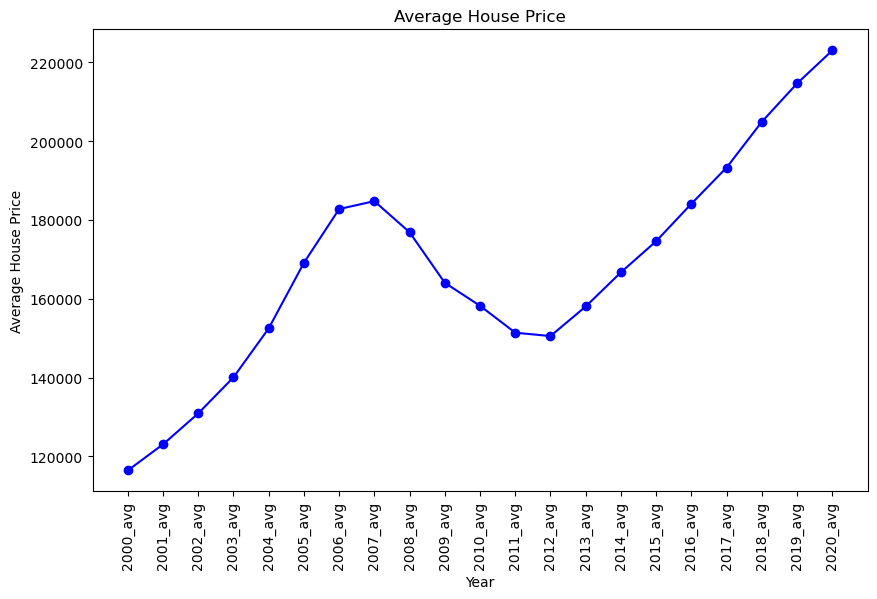

In [159]:
plt.figure(figsize=(10, 6))

plt.plot(yearly_avg_houseprice.index, yearly_avg_houseprice.values, marker='o', linestyle='-', color='b')
plt.title('Average House Price')
plt.xlabel('Year')
plt.ylabel('Average House Price')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'RNETMIG2001'),
  Text(1, 0, 'RNETMIG2002'),
  Text(2, 0, 'RNETMIG2003'),
  Text(3, 0, 'RNETMIG2004'),
  Text(4, 0, 'RNETMIG2005'),
  Text(5, 0, 'RNETMIG2006'),
  Text(6, 0, 'RNETMIG2007'),
  Text(7, 0, 'RNETMIG2008'),
  Text(8, 0, 'RNETMIG2009'),
  Text(9, 0, 'RNETMIG2010'),
  Text(10, 0, 'RNETMIG2011'),
  Text(11, 0, 'RNETMIG2012'),
  Text(12, 0, 'RNETMIG2013'),
  Text(13, 0, 'RNETMIG2014'),
  Text(14, 0, 'RNETMIG2015'),
  Text(15, 0, 'RNETMIG2016'),
  Text(16, 0, 'RNETMIG2017'),
  Text(17, 0, 'RNETMIG2018'),
  Text(18, 0, 'RNETMIG2019'),
  Text(19, 0, 'RNETMIG2020')])

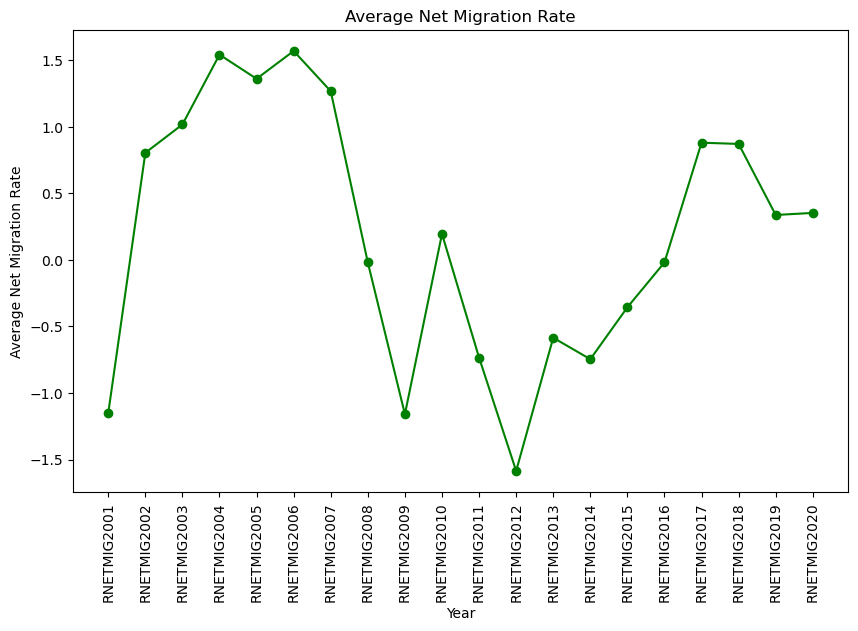

In [160]:
plt.figure(figsize=(10, 6))

plt.plot(yearly_avg_net_migration.index, yearly_avg_net_migration.values, marker='o', linestyle='-', color='g')
plt.title('Average Net Migration Rate')
plt.xlabel('Year')
plt.ylabel('Average Net Migration Rate')
plt.xticks(rotation=90)

In [170]:
houseprice_new = pd.read_csv(r"F:\LongMigration\Data\houseprice.csv")

In [189]:
houseprice_new_county = pd.merge(houseprice_new,county,on="FIPS")

In [191]:
gdf_houseprice_new_county = gpd.GeoDataFrame(houseprice_new_county,geometry="geometry")

In [192]:
gdf_houseprice_new_county.to_file(r"F:\LongMigration\Data\houseprice.shp")

In [176]:
houseprice_new['FIPS'] = houseprice_new['FIPS'].astype("str").str.rjust(5,"0")

In [177]:
columns_nor = ["average","changerate"]  
houseprice_new[columns_nor] = (houseprice_new[columns_nor] - houseprice_new[columns_nor].mean()) / houseprice_new[columns_nor].std()

In [178]:
houseprice_hurricane = houseprice_new[houseprice_new["FIPS"].isin(SHELDUS_hurricane_county)].reset_index()
houseprice_no_hurricane = houseprice_new[~houseprice_new["FIPS"].isin(SHELDUS_hurricane_county)].reset_index()

In [179]:
houseprice_hurricane_merge = pd.merge(houseprice_hurricane,SVI_10_merge,on="FIPS")
houseprice_no_hurricane_merge = pd.merge(houseprice_no_hurricane,SVI_10_merge,on="FIPS")

In [180]:
houseprice_hurricane_merge

,index,FIPS,2000_avg,2001_avg,2002_avg,2003_avg,2004_avg,2005_avg,2006_avg,2007_avg,...,minority,LessThanWellEnglish5+,HouseWith10+Units,MobileHome,HouseWithPop>Room,NoVehicleHousehold,GroupQuarters,NetMigrationRateTotal,NetMigrationRateDome,NetMigrationRateInter
0,2,48201,112247.16900,113406.77480,116525.58270,120323.79530,127285.96150,133548.67730,135378.19640,139650.06090,...,0.6702,0.126157,0.257339,0.027310,0.062299,0.071377,0.0109,4.931889,-1.781172,6.713061
1,7,12086,125225.30660,133518.47580,151344.68360,176469.35320,206191.14590,258062.71840,317589.56570,329039.69120,...,0.8464,0.223398,0.358670,0.014516,0.052033,0.110637,0.0160,2.410780,-12.265068,14.675848
2,17,12011,104257.50230,116326.59770,135112.63480,152524.65680,177477.56220,220240.79760,264488.91110,262188.50390,...,0.5648,0.072379,0.352875,0.028674,0.031562,0.071326,0.0097,6.105865,-1.744854,7.850719
3,21,25017,276136.97750,311238.28680,347350.05700,381897.36430,409587.61030,437948.60590,432558.80700,413143.50040,...,0.2347,0.037714,0.168938,0.003335,0.015248,0.107448,0.0369,0.820502,-5.473038,6.293539
4,25,12099,126672.62040,134590.31470,151466.79020,173725.87510,205249.56880,257808.87210,306043.50480,282243.93040,...,0.3989,0.063605,0.252341,0.029023,0.025568,0.061799,0.0151,12.241586,6.424271,5.817315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,1058,13197,65826.76924,70475.51887,77157.39362,82304.37873,88801.70316,84851.19404,87153.72257,90357.93541,...,0.4166,0.016049,0.011824,0.352453,0.020183,0.135289,0.0090,-4.107738,-6.194525,2.086787
328,1060,47095,47636.63160,49155.75726,48951.72576,50130.90081,51785.78039,55157.39702,58827.98803,61314.73457,...,0.3094,0.004127,0.028223,0.092677,0.013043,0.102609,0.3200,-6.197262,-6.316486,0.119224
329,1065,13283,66840.88137,72580.62304,73086.96303,73777.27235,74207.31658,77115.69471,81896.95143,83552.96216,...,0.3513,0.003467,0.000000,0.296097,0.004006,0.070913,0.0656,-0.052435,-1.103157,1.050723
330,1068,13263,59978.13835,65147.16740,68905.29193,72862.20562,77131.20510,82147.98858,89142.69757,94245.91196,...,0.6156,0.000000,0.000000,0.227572,0.019761,0.126771,0.0025,-5.009749,-5.086258,0.076509


Text(0.5, 1.0, 'Counties with hurricane affected')

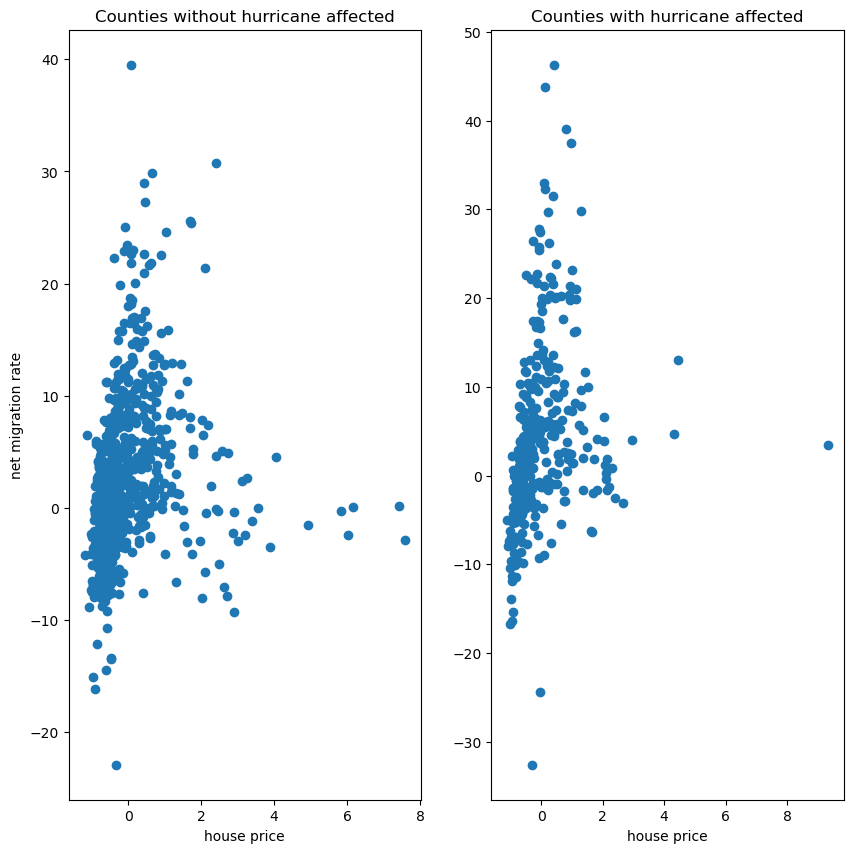

In [187]:
fig, axes = plt.subplots(1,2,figsize=(10,10))
axes[0].scatter(houseprice_no_hurricane_merge['average'], houseprice_no_hurricane_merge['NetMigrationRateTotal'])
axes[0].set_xlabel("house price")
axes[0].set_ylabel("net migration rate")
axes[0].set_title("Counties without hurricane affected")

axes[1].scatter(houseprice_hurricane_merge['average'], houseprice_hurricane_merge['NetMigrationRateTotal'])
axes[1].set_xlabel("house price")
# axes[1].set_ylabel("net migration rate")
axes[1].set_title("Counties with hurricane affected")

In [195]:
gdf_NMR.to_file(r"F:\LongMigration\Data\NMR.shp")

C:\Users\xiang11\AppData\Local\Temp\ipykernel_7644\4265971210.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_NMR.to_file(r"F:\LongMigration\Data\NMR.shp")
